In [1]:
import time
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, random_split
import matplotlib.pyplot as plt
from torchsummary import summary

In [2]:
class BCNN(nn.Module):
    def __init__(self):
        super(BCNN, self).__init__()
        # VGG16的卷积层和池化层
        self.features = torchvision.models.vgg16(pretrained=True).features
        self.features = nn.Sequential(*list(self.features.children())[:-1])  # 去除最后的池化层
        # 线性分类层
        self.fc = nn.Linear(512 * 512, 200)
        # 冻结以前的所有层
        for param in self.features.parameters():
            param.requres_grad = False
        # 初始化全连接层
        nn.init.kaiming_normal_(self.fc.weight.data)
        if self.fc.bias is not None:
            nn.init.constant_(self.fc.bias.data, val=0)

    def forward(self, x):
        N = x.size()[0]
        x = self.features(x)
        x = x.view(N, 512, 28 * 28)  # 改变tensor形状
        x = torch.bmm(x, torch.transpose(x, 1, 2)) / (28 * 28)  # 双线性池化层，使用bmm函数对所有位置L进行批量矩阵乘计算，得到512*512的矩阵
        x = x.view(N, 512 * 512)  # 将bilinear matrix拉直为bilinear vector
        x = torch.sqrt(x + 1e-5)  # 将bilinear vector开方
        x = torch.nn.functional.normalize(x)  # 将bilinear vector归一化
        x = self.fc(x)  # 传入全连接层
        return x

In [3]:
# 输出网络模型结构
summary(BCNN(), input_size=(3, 448, 448), batch_size=32, device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 64, 448, 448]           1,792
              ReLU-2         [32, 64, 448, 448]               0
            Conv2d-3         [32, 64, 448, 448]          36,928
              ReLU-4         [32, 64, 448, 448]               0
         MaxPool2d-5         [32, 64, 224, 224]               0
            Conv2d-6        [32, 128, 224, 224]          73,856
              ReLU-7        [32, 128, 224, 224]               0
            Conv2d-8        [32, 128, 224, 224]         147,584
              ReLU-9        [32, 128, 224, 224]               0
        MaxPool2d-10        [32, 128, 112, 112]               0
           Conv2d-11        [32, 256, 112, 112]         295,168
             ReLU-12        [32, 256, 112, 112]               0
           Conv2d-13        [32, 256, 112, 112]         590,080
             ReLU-14        [32, 256, 1

D:\anaconda3\lib\site-packages\torchsummary\torchsummary.py:93: RuntimeWarning: overflow encountered in long_scalars
  total_output += np.prod(summary[layer]["output_shape"])


In [4]:
train_val_split = 0.9  # 数据集划分比
BATCH_SIZE = 32  # 一次抓取的样本数量
dataset = './data/images'


class DatasetFromSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)


def data_process():
    train_transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize(size=448),  
        torchvision.transforms.RandomHorizontalFlip(),  # 随机翻转
        torchvision.transforms.RandomCrop(size=448),
        torchvision.transforms.ToTensor(),
        # 归一化
        torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406),
                                         std=(0.229, 0.224, 0.225))
    ])
    test_transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize(size=448),
        torchvision.transforms.RandomCrop(size=448),
        torchvision.transforms.ToTensor(),
        # 归一化
        torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406),
                                         std=(0.229, 0.224, 0.225))
    ])

    # 生成训练集与测试集
    data = torchvision.datasets.ImageFolder(root=dataset)
    data_len = len(data)
    train_len = int(train_val_split * data_len)
    test_len = data_len - train_len
    train_subset, test_subset = random_split(data, [train_len, test_len])
    train_data = DatasetFromSubset(train_subset, transform=train_transforms)
    test_data = DatasetFromSubset(test_subset, transform=test_transforms)
    train_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               num_workers=0,
                                               pin_memory=True)
    test_loader = torch.utils.data.DataLoader(test_data,
                                              batch_size=BATCH_SIZE,
                                              shuffle=True,
                                              num_workers=0,
                                              pin_memory=True)
    return train_loader, test_loader

In [5]:
# 配置GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 加载数据
train_loader, test_loader = data_process()

BASE_LEARNING_RATE = 0.05
EPOCHS = 100
WEIGHT_DECAY = 0.00001

In [7]:
net = BCNN().to(device)

# 损失函数使用交叉熵损失函数
criterion = nn.CrossEntropyLoss().cuda()
# 优化器使用SGD
optimizer = torch.optim.SGD(net.fc.parameters(),
                            lr=BASE_LEARNING_RATE,
                            momentum=0.9,
                            weight_decay=WEIGHT_DECAY)
# 调整学习率
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True, threshold=1e-4)

# 训练模型
print('Start Training')
total_step = len(train_loader)
best_model_wts = net.state_dict()
best_acc = 0.0
record_train = list()
record_test = list()

for epoch in range(EPOCHS):
    # 保存训练过程文件
    mylog = open('BCNN_training_progress.log', mode='a', encoding='utf-8')
    print("========== epoch: [{}/{}] ==========".format(epoch + 1, EPOCHS), file=mylog)
    print("========== epoch: [{}/{}] ==========".format(epoch + 1, EPOCHS))
    epoch_loss = []
    num_correct = 0
    num_total = 0
    start = time.time()
    for i, (images, labels) in enumerate(train_loader):
        # 数据转为cuda
        images = torch.autograd.Variable(images.cuda())
        labels = torch.autograd.Variable(labels.cuda())
        # 梯度清零
        optimizer.zero_grad()
        # 前向传播
        outputs = net(images)
        loss = criterion(outputs, labels)
        epoch_loss.append(loss.data)
        # 后向传播
        loss.backward()
        optimizer.step()
        # 预测
        _, prediction = torch.max(outputs.data, 1)
        num_total += labels.size(0)
        num_correct += torch.sum(prediction == labels.data)
        train_acc = 100.0 * num_correct / num_total

        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Training Loss: {:.4f} | Training accuracy: {:6.3f}%'.
                  format(epoch + 1, EPOCHS, i + 1, total_step, loss.item(), train_acc))
            print('Epoch [{}/{}], Step [{}/{}], Training Loss: {:.4f} | Training accuracy: {:6.3f}%'.
                  format(epoch + 1, EPOCHS, i + 1, total_step, loss.item(), train_acc), file=mylog)

    record_train.append(train_acc)
    print('Epoch:%d Training Loss:%.03f Acc: %.03f' % (epoch + 1, sum(epoch_loss) / len(epoch_loss), train_acc))
    print('Epoch:%d Training Loss:%.03f Acc: %.03f' % (epoch + 1, sum(epoch_loss) / len(epoch_loss), train_acc), file=mylog)
    print("--- cost time: {:.4f}s ---".format(time.time() - start))
    print("--- cost time: {:.4f}s ---".format(time.time() - start), file=mylog)

    # 在测试集上进行测试
    print("*************** test ***************")
    print("*************** test ***************", file=mylog)
    with torch.no_grad():
        num_correct = 0
        num_total = 0
        for images, labels in test_loader:
            net.eval()
            images = torch.autograd.Variable(images.cuda())
            labels = torch.autograd.Variable(labels.cuda())

            outputs = net(images)
            _, prediction = torch.max(outputs.data, 1)
            num_total += labels.size(0)
            num_correct += torch.sum(prediction == labels.data).item()

    test_acc = 100 * num_correct / num_total
    if test_acc > best_acc:
        best_acc = test_acc
        best_model_wts = net.state_dict()
    record_test.append(test_acc)
    print("test_loss: {:.3f} | test_acc: {:6.3f}%".format(loss.item(), test_acc))
    print("test_loss: {:.3f} | test_acc: {:6.3f}%".format(loss.item(), test_acc), file=mylog)
    print("************************************\n")
    print("************************************\n", file=mylog)
    mylog.close()

# 保存最好的模型
net.load_state_dict(best_model_wts)
model_name = "BCNN_savedModel_{:6.3f}%.pth".format(best_acc)
torch.save(net, model_name)
print("Training finished! Model saved to " + model_name)

Start Training
========== epoch: [1/100] ==========
Epoch [1/100], Step [100/332], Training Loss: 5.2818 | Training accuracy:  0.938%
Epoch [1/100], Step [200/332], Training Loss: 5.2501 | Training accuracy:  1.125%
Epoch [1/100], Step [300/332], Training Loss: 5.2040 | Training accuracy:  3.323%
Epoch:1 Training Loss:5.256 Acc: 4.044
--- cost time: 158.5514s ---
*************** test ***************
test_loss: 5.193 | test_acc:  9.584%
************************************

========== epoch: [2/100] ==========
Epoch [2/100], Step [100/332], Training Loss: 5.1625 | Training accuracy: 14.031%
Epoch [2/100], Step [200/332], Training Loss: 5.1403 | Training accuracy: 15.031%
Epoch [2/100], Step [300/332], Training Loss: 5.0594 | Training accuracy: 16.646%
Epoch:2 Training Loss:5.144 Acc: 17.268
--- cost time: 158.9415s ---
*************** test ***************
test_loss: 5.117 | test_acc: 18.745%
************************************

========== epoch: [3/100] ==========
Epoch [3/100], Step [

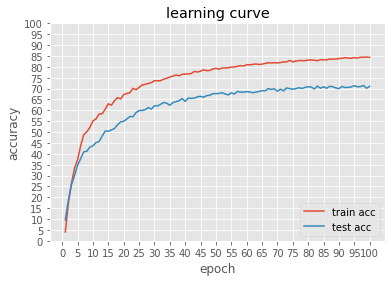

In [ ]:
# 可视化训练过程
train_acc_result = []
for record in record_train:
    train_acc_result.append(record.cuda().data.cpu().numpy())

plt.style.use("ggplot")
plt.plot(range(1, len(train_acc_result) + 1), train_acc_result, label="train acc")
if record_test is not None:
    plt.plot(range(1, len(record_test) + 1), record_test, label="test acc")

plt.legend(loc=4)
plt.title("learning curve")
plt.xticks(range(0, len(train_acc_result) + 1, 5))
plt.yticks(range(0, 101, 5))
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.show()